# Práctica 2

## Preparación de entorno

In [25]:
import numpy as np
import keras as ker
import matplotlib.pyplot as plt 
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

## SETUP

### Lectura y limpieza dataset

In [26]:
cancer = pd.read_csv("cancer_dataset.csv", encoding = 'latin_1', sep = ',')
cancer = cancer.drop(columns=['id'], axis=1) # No sirve

cancerentreno, cancerpredecir = train_test_split(cancer, test_size = 0.30, shuffle=False) # El entreno es el 70% y el conjunto prueba 30%

esperadas_entreno = cancerentreno.pop("diagnosis")
esperadas_predecir = cancerpredecir.pop("diagnosis")

### Variables a definir

In [27]:
entradas =  cancerentreno.to_numpy() # Las 30 posibles variables
esperadas = esperadas_entreno.to_numpy() # Array de B/M con el diagnóstico

# Categorizamos el diagnostico de entreno (M = 1 / B = 0)
label_encoder = LabelEncoder()
esperadas = label_encoder.fit_transform(esperadas)

# Categorizamos el diagnostico de predicción (M = 1 / B = 0)
esperadas_predecir = label_encoder.fit_transform(esperadas_predecir)

nNeuronasCapaOculta = 12 # Tocar
nCapasOcultas = 5 # Tocar
Epoch = 500 # Tocar
tam_entrada = cancerentreno.shape[1] # Tamaño de la capa de entrada = columnas

def validar_neuronas_oculta(M,N,n): # Empleamos esta funcion para validar que las neuronas de la capa oculta cumplen con la regla aprendida en clase
    # La regla a validar es (M/2N < n < 2M/N)
    # Siendo M: ejemplos de entrenamiento // N: neuronas de entrada // n: neuronas de la capa oculta
    if((M/(2*N)) < n and n < ((2*M)/N)):
        return print("Neuronas de la capa oculta cumple regla") # validamos
    return print("Neuronas de la capa oculta no cumple regla")

validar_neuronas_oculta(cancerentreno.shape[0],tam_entrada,nNeuronasCapaOculta)

Neuronas de la capa oculta cumple regla


### Creación y ajuste de la red

In [28]:
MLP = ker.Sequential() # Creamos el modelo vacío

# Añadimos la primera capa (tecnicamente dos, la de entrada (con la variable input_dim) y la oculta)
MLP.add(ker.layers.Dense(nNeuronasCapaOculta, input_dim = tam_entrada, activation='relu'))

# Añadimos tantas capas ocultas extra como queramos (siempre como mínimo hay 1, la creada anteriormente)
for i in range(nCapasOcultas):
    MLP.add(ker.layers.Dense(nNeuronasCapaOculta, activation='relu'))

# Añadimos la capa de salida
MLP.add(ker.layers.Dense(1,activation='sigmoid')) 

# MLP.summary()

# Por último tenemos que configurar el modelo antes de entrenarlo con lo dicho en el enunciado
# Optimizador: Adam
# Función error: Mean Squared Error
# Metricas = Binary accuracy porque nos da el número de precisión de la red
MLP.compile(optimizer='adam',loss='mean_squared_error',metrics=["binary_accuracy"])


### Entrenamiento de la red

In [29]:
# Por último entrenamos la red con el epoch (nº iteraciones)
output_fit = MLP.fit(entradas,esperadas,epochs=Epoch,verbose = 0) 

### Calidad de la red

dict_keys(['loss', 'binary_accuracy'])


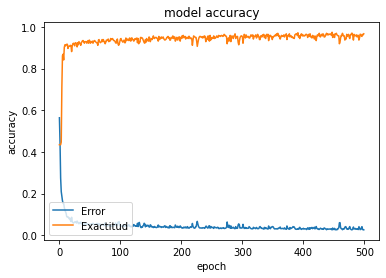

Datos evaluadis
13/13 [==============================] - 0s 7ms/step - loss: 0.0296 - binary_accuracy: 0.9573
Error, Exactitud: [0.029582608491182327, 0.9572864174842834]


In [30]:
print(output_fit.history.keys())
# Pintamos las tanto la loss como la accuracy
plt.plot(output_fit.history['loss'])
plt.plot(output_fit.history['binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Error', 'Exactitud'], loc='lower left')
plt.show()

# Evaluamos el modelo
print("Datos evaluadis")
evaluar = MLP.evaluate(entradas, esperadas)
print("Error, Exactitud:", evaluar)

### Prueba de la red

In [31]:
# Una vez tenemos entrenada la red, probamos todas las entradas y vemos si funciona
i = 0
fallos = 0
resultados = MLP.predict(cancerpredecir).round()
print("================ EXACTITUD ================")
for resultado in resultados:
    print("PREDICHO ->", resultado, " ESPERADO ->", esperadas_predecir[i])
    if(resultado != esperadas_predecir[i]):
        fallos += 1
    i += 1

print("Número de fallos: ", fallos, " de ", cancerpredecir.shape[0], "porcentaje de fallo: ", fallos/cancerpredecir.shape[0])

================ EXACTITUD ================
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [1.]  ESPERADO -> 1
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [1.]  ESPERADO -> 1
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [1.]  ESPERADO -> 1
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [1.]  ESPERADO -> 1
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -> 0
PREDICHO -> [0.]  ESPERADO -